In [41]:
import math
import warnings
import numpy as np
import pandas as pd
from data.time import process_data
#from data.data import process_data2
from keras.models import load_model
from keras.utils.vis_utils import plot_model
import sklearn.metrics as metrics
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn import svm

In [42]:
lag = 12
file1 = 'data/train.csv'
file2 = 'data/test.csv'
X_train, y_train, X_test, y_test, scaler = process_data(file1, file2, lag)

/Users/yipinghsu/School/deep/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [43]:
from keras import backend as K
def get_activations(model, layer, X_batch):
    get_activations = K.function([model.layers[0].input, K.learning_phase()], [model.layers[layer].output,])
    activations = get_activations([X_batch,1])
    return activations

In [44]:
lstm = load_model('model/lstm.h5')
print(lstm.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 12, 64)            16896     
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 49,985
Trainable params: 49,985
Non-trainable params: 0
_________________________________________________________________
None


In [45]:
x_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
x_train_representation = get_activations(lstm, 2, x_train)[0]
x_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
x_test_representation = get_activations(lstm, 2, x_test)[0]

In [46]:
print(X_test.shape)
print(x_test_representation.shape)

(4308, 12)
(4308, 64)


In [156]:
model = svm.SVC(decision_function_shape='ovo')
model.fit(x_train_representation, y_train)
#y_pred = model.predict(x_test_representation)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovo', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [157]:
y_pred = model.predict(x_test_representation)

In [158]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_pred)

0.39740018570102137

In [159]:
from sklearn.metrics import confusion_matrix
cnf_matrix_test = confusion_matrix(y_test, y_pred)

In [160]:
import itertools
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


Confusion matrix, without normalization


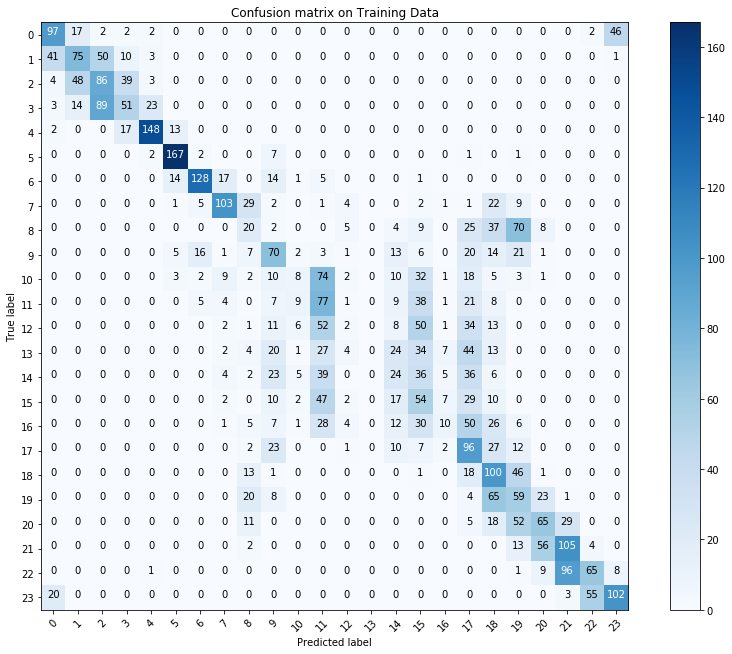

In [161]:
class_names=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23]
plt.figure(figsize=(12, 9))
plot_confusion_matrix(cnf_matrix_test, classes=class_names,
                      title='Confusion matrix on Training Data')

In [130]:
def rolling(y_true, y_pred):
    error = 0
    for true, pred in zip(y_true, y_pred):
        error += min(abs(true-pred + 24)%24, abs(pred-true+24)%24)
        
    return error/len(y_true)
    

In [136]:
from sklearn.metrics import accuracy_score, mean_absolute_error,make_scorer
maem = make_scorer(lambda y_true, y_pred: rolling(y_true, y_pred),
                   greater_is_better=False)
maem = maem(model, x_test_representation, y_test)
np.average(maem)

-1.9041318477251625

In [165]:
from sklearn.model_selection import GridSearchCV
def my_scorer(clf, X, y_true):
    y_pred = clf.predict(X)
    error = 0
    for true, pred in zip(y_true, y_pred):
        error += min(abs(true-pred + 24)%24, abs(pred-true+24)%24)
    return -error

gs = GridSearchCV(
    estimator=svm.SVR(),
    param_grid = [
      {'C': [1, 10, 100, 1000], 'kernel': ['linear']},
      {'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001], 'kernel': ['rbf']},
    ],
    scoring=my_scorer) 
model = gs.fit(x_train_representation, y_train)

In [166]:
y_pred = model.predict(x_test_representation)
rolling(y_test, y_pred)

2.8673087831670157

In [170]:
rolling([0, 1],[23.5, 2])

0.75

In [ ]:
how far from hour
time of year
how far from day of the week (weekday or weekend)